In [1]:
import pandas as pd
import numpy as np
import sys, zipfile, os, time
import matplotlib.pyplot as plt
import glob
import datetime
import urllib3
import cdsapi
import xarray
import shutil
import warnings
import pickle
import h5py
import netCDF4
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua

In [2]:
def get_adj(station):
    import datetime
    """Compare created adjustment to downloaded adjustment
    """
    date0 = datetime.datetime.strptime('1900-01-01', "%Y-%m-%d")

    file = glob.glob('./Humidity_adjustments/files/dest_*_relative_humidity_adjusted.nc')[0]
    data = eua.CDMDataset(file).to_dataframe()
    daydata = data[data.time.dt.hour > 6][data.time.dt.hour <= 18]
    nightdata = data[data.time.dt.hour <= 6].append(data[data.time.dt.hour > 18])
    
    c = cdsapi.Client()
    r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
                   {'variable': 'relative_humidity',
                    'optional':['humidity_bias_estimate'],
                    'statid': station,
                    'pressure_level':[10,20,30,50,70,100,150,200,250,300,400,500,700,850,925,1000]
                   }
                  )
    r.download(target='download.zip')
    assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
    z = zipfile.ZipFile('download.zip')
    z.extractall(path='./tocompare/hur/cds_'+station)
    z.close()
    cdsfile = glob.glob('./tocompare/hur/cds_'+ station +'/*.nc')
    cdsdata=eua.CDMDataset(cdsfile[0]).to_dataframe()
    daycdsdata = cdsdata[cdsdata.time.dt.hour > 6][cdsdata.time.dt.hour <= 18]
    nightcdsdata = cdsdata[cdsdata.time.dt.hour <= 6].append(cdsdata[cdsdata.time.dt.hour > 18])
    
    return daydata, nightdata, daycdsdata, nightcdsdata

In [3]:
def plt_adj(cdata, adata, plev, station, time, adj, save):
    cdata = cdata[cdata.plev == plev*100]
    adata = adata[adata.plev == plev*100]
    fig, ax = plt.subplots()
    ax.scatter(cdata['time'], cdata.humidity_bias_estimate, label='CDS', s=50)
    ax.scatter(adata['time'], adata.hur_bias_estimate, label='Calc', s=20)

    ax.set(xlabel='time', ylabel='Adjustment: '+adj,
           title= str(station)+' Humidity '+str(plev)+' hPa '+time)
    ax.legend()
    ax.grid()
    
    if save:
        fig.savefig(str(station)+'_Humidity_'+str(plev)+'_hPa_'+time+'.png')
    plt.show()
    return

In [4]:
# DOWNLOAD DATA FROM CDS:
home = os.getcwd()
%run gethum.py # downloading just: ['0-20001-0-11035', '0-20001-0-10393', '0-20001-0-70219', '0-20000-0-91413', '0-20000-0-35229', '0-20000-0-68994']
os.chdir(home)

./


In [5]:
files = glob.glob('Humidity_adjustments/files/downloaded/*/*72357*relative_humidity.nc')
display(files)

['Humidity_adjustments/files/downloaded/downloaded_72357/dest_0-20000-0-72357_relative_humidity.nc']

In [6]:
# RUN ADJUSTMENTS
import subprocess
for i in files:
    exc = ['./raso_adj_cdm_v1.py', '-f', './'+i, '--humidity', '--verbose']
    list_files = subprocess.run(exc)


2021-07-02 11:21:20,107 INFO Reading Profile on slice(None, None, None)
2021-07-02 11:21:22,822 INFO Welcome to the CDS
2021-07-02 11:21:22,823 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-07-02 11:21:23,036 INFO Request is queued
2021-07-02 11:21:24,073 INFO Request is running
2021-07-02 11:21:27,899 INFO Request is completed
2021-07-02 11:21:27,900 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1625217686.488145-658-16-79a747bf-79bb-49ab-ae91-1f785dc335e9.zip to download.zip (16.6M)
2021-07-02 11:21:29,504 INFO Download rate 10.4M/s  
2021-07-02 11:21:29,801 INFO Reading Profile on slice(None, None, None)


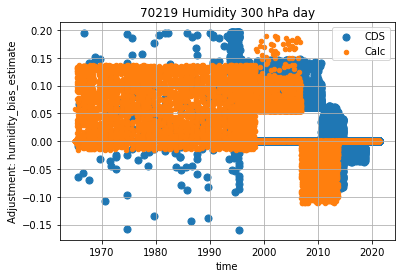

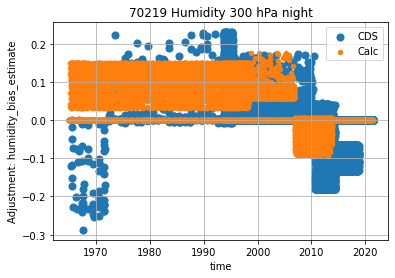

In [26]:
station = '70219'
dd, nd, dcd, ncd = get_adj(station)

plt_adj(dcd[dcd.time > '1965'], dd[dd.time > '1965'], 300, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd[ncd.time > '1965'], nd[nd.time > '1965'], 300, station, 'night', 'humidity_bias_estimate', save=True)
# plt_adj(dcd, dd, 500, station, 'day', 'humidity_bias_estimate', save=True)
# plt_adj(ncd, nd, 500, station, 'night', 'humidity_bias_estimate', save=True)
# plt_adj(dcd, dd, 850, station, 'day', 'humidity_bias_estimate', save=True)
# plt_adj(ncd, nd, 850, station, 'night', 'humidity_bias_estimate', save=True)

2021-07-02 08:52:22,825 INFO Welcome to the CDS
2021-07-02 08:52:22,826 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-07-02 08:52:23,073 INFO Request is completed
2021-07-02 08:52:23,075 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1625138190.0704494-16300-4-ebb0fa48-b6a4-4865-b241-6a98472d6bec.zip to download.zip (21.1M)
2021-07-02 08:52:26,509 INFO Download rate 6.1M/s   
2021-07-02 08:52:26,624 INFO Reading Profile on slice(None, None, None)


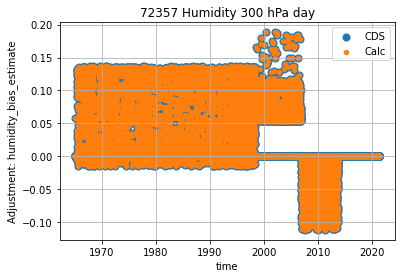

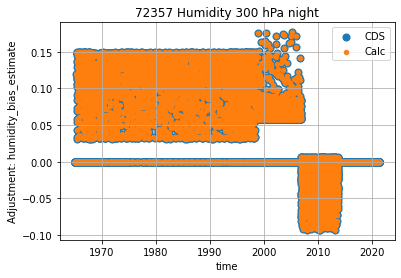

In [7]:
station = '72357'
dd, nd, dcd, ncd = get_adj(station)

plt_adj(dcd[dcd.time > '1965'], dd[dd.time > '1965'], 300, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd[ncd.time > '1965'], nd[nd.time > '1965'], 300, station, 'night', 'humidity_bias_estimate', save=True)
# plt_adj(dcd, dd, 500, station, 'day', 'humidity_bias_estimate', save=True)
# plt_adj(ncd, nd, 500, station, 'night', 'humidity_bias_estimate', save=True)
# plt_adj(dcd, dd, 850, station, 'day', 'humidity_bias_estimate', save=True)
# plt_adj(ncd, nd, 850, station, 'night', 'humidity_bias_estimate', save=True)

In [8]:
# station = '91413'
# dd, nd, dcd, ncd = get_adj(station)

# plt_adj(dcd, dd, 100, station, 'day', 'humidity_bias_estimate', save=True)
# plt_adj(ncd, nd, 100, station, 'night', 'humidity_bias_estimate', save=True)
# plt_adj(dcd, dd, 500, station, 'day', 'humidity_bias_estimate', save=True)
# plt_adj(ncd, nd, 500, station, 'night', 'humidity_bias_estimate', save=True)
# plt_adj(dcd, dd, 850, station, 'day', 'humidity_bias_estimate', save=True)
# plt_adj(ncd, nd, 850, station, 'night', 'humidity_bias_estimate', save=True)

2021-07-02 08:52:30,640 INFO Reading Profile on slice(None, None, None)
2021-07-02 08:52:32,868 INFO Welcome to the CDS
2021-07-02 08:52:32,870 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-07-02 08:52:33,036 INFO Request is completed
2021-07-02 08:52:33,037 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1625138448.9778574-12234-15-605fab37-c465-48a5-b154-750282c953fb.zip to download.zip (17.8M)
2021-07-02 08:52:34,755 INFO Download rate 10.4M/s  
2021-07-02 08:52:34,880 INFO Reading Profile on slice(None, None, None)


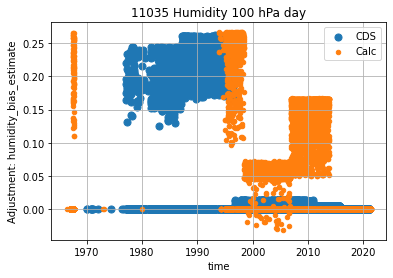

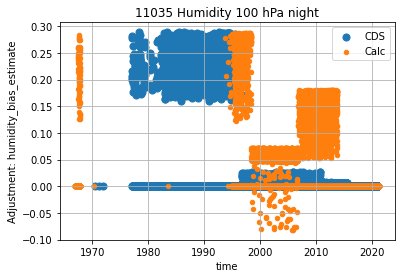

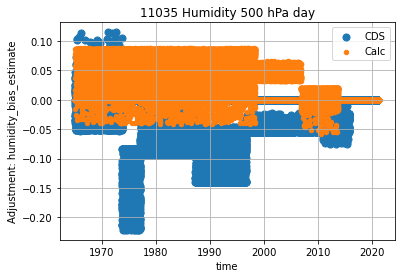

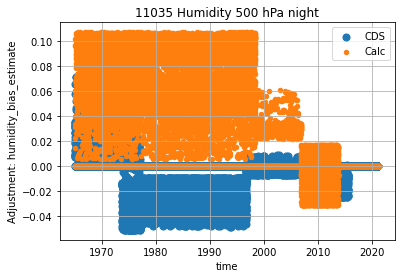

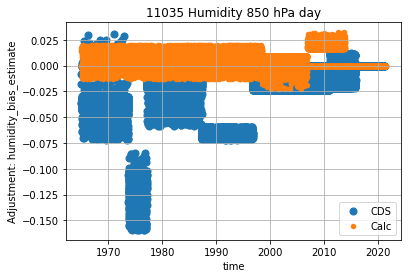

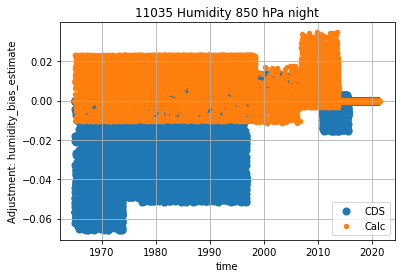

In [9]:
station = '11035'
dd, nd, dcd, ncd = get_adj(station)

plt_adj(dcd[dcd.time > '1965'], dd[dd.time > '1965'], 100, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd[ncd.time > '1965'], nd[nd.time > '1965'], 100, station, 'night', 'humidity_bias_estimate', save=True)
plt_adj(dcd[dcd.time > '1965'], dd[dd.time > '1965'], 500, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd[ncd.time > '1965'], nd[nd.time > '1965'], 500, station, 'night', 'humidity_bias_estimate', save=True)
plt_adj(dcd[dcd.time > '1965'], dd[dd.time > '1965'], 850, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd[ncd.time > '1965'], nd[nd.time > '1965'], 850, station, 'night', 'humidity_bias_estimate', save=True)

In [16]:
a = glob.glob('./Humidity_adjustments/files/*11035*')
b = eua.CDMDataset(a[0])
b

File: <HDF5 file "dest_0-20001-0-11035_relative_humidity_adjusted.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 21.69 MB
Filename: ./Humidity_adjustments/files/dest_0-20001-0-11035_relative_humidity_adjusted.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (425667,)
 - V | hur__________________________________________ : : (425667,)
 - V | hur_bias_estimate____________________________ : : (425667,)
 - V | hur_breakpoints______________________________ : : (425667,)
 - V | hur_snht_test________________________________ : : (425667,)
 - V | lat__________________________________________ : : (425667,)
 - V | lon__________________________________________ : : (425667,)
 - V | obs__________________________________________ : : (425667,)
 - V | obs_minus_bg_________________________________ : : (425667,)
 - V | plev_________________________________________ : : (425667,)
 - V | report_id____________________________________ : : (425667, 11)
 - V | station_id__

In [24]:
c = b.to_dataframe(variables=['hur', 'time', 'plev'])
c = c[c.time > '1965']
c

2021-07-02 08:56:18,963 INFO Reading Profile on slice(None, None, None)


,hur,time,plev
37642,0.4908,1965-01-01 03:00:00,40000.0
37643,0.6728,1965-01-01 03:00:00,50000.0
37644,0.2718,1965-01-01 03:00:00,70000.0
37645,0.2308,1965-01-01 03:00:00,85000.0
37646,0.3224,1965-01-01 12:00:00,2000.0
...,...,...,...
425662,NaN,2020-12-31 11:30:10,40000.0
425663,NaN,2020-12-31 11:30:10,50000.0
425664,NaN,2020-12-31 11:30:10,70000.0
425665,NaN,2020-12-31 11:30:10,85000.0


In [25]:
c[~ np.isnan(c.hur)]

,hur,time,plev
37642,0.490800,1965-01-01 03:00:00,40000.0
37643,0.672800,1965-01-01 03:00:00,50000.0
37644,0.271800,1965-01-01 03:00:00,70000.0
37645,0.230800,1965-01-01 03:00:00,85000.0
37646,0.322400,1965-01-01 12:00:00,2000.0
...,...,...,...
409419,0.462836,2019-09-30 23:30:11,40000.0
409420,0.572449,2019-09-30 23:30:11,50000.0
409421,0.187847,2019-09-30 23:30:11,70000.0
409422,0.632444,2019-09-30 23:30:11,85000.0


File: <HDF5 file "dest_0-20000-0-72357_relative_humidity_adjusted.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 24.86 MB
Filename: ./Humidity_adjustments/files/downloaded/downloaded_72357/dest_0-20000-0-72357_relative_humidity_adjusted.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (479849,)
 - V | hur__________________________________________ : : (479849,)
 - V | hur_bias_estimate____________________________ : : (479849,)
 - V | hur_breakpoints______________________________ : : (479849,)
 - V | hur_snht_test________________________________ : : (479849,)
 - V | lat__________________________________________ : : (479849,)
 - V | lon__________________________________________ : : (479849,)
 - V | obs__________________________________________ : : (479849,)
 - V | obs_minus_bg_________________________________ : : (479849,)
 - V | plev_________________________________________ : : (479849,)
 - V | report_id____________________________________ : : (479

2021-07-02 08:52:42,475 INFO Reading Profile on slice(None, None, None)


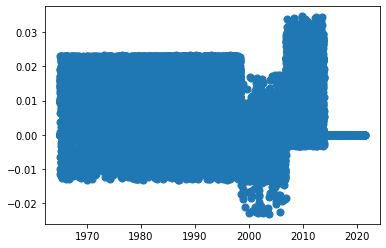

In [11]:
a = glob.glob('./Humidity_adjustments/files/downloaded/downloaded_72357/*_adjus*')
b = eua.CDMDataset(a[0])
display(b)

df = b.to_dataframe(variables=['time', 'hur_bias_estimate', 'hur', 'plev' ])

test = df[df.time > '1965'][df.plev == 85000]

fig, ax = plt.subplots()
ax.scatter(test.time, test.hur_bias_estimate, label='CDS', s=50)
plt.show()

2021-07-02 08:52:43,129 INFO Reading Profile on slice(None, None, None)


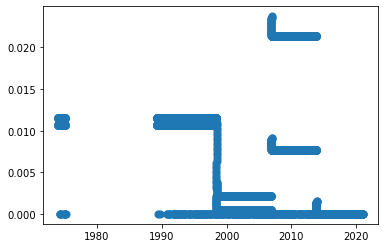

In [12]:
a = glob.glob('/raid60/scratch/leo/scratch/converted_v5/*72357*')
b = eua.CDMDataset(a[0])
b.recordindices['38'][:]

df = b.to_dataframe(groups=['observations_table', 'advanced_homogenisation' ], 
                    variables=['date_time', 'humidity_bias_estimate', 'observed_variable', 'z_coordinate' ])

test = df[df.observed_variable == 38][df.date_time > '1965'][df.z_coordinate == 85000]

fig, ax = plt.subplots()
ax.scatter(test.date_time, test.humidity_bias_estimate, label='CDS', s=50)
plt.show()

2021-07-02 08:52:44,909 INFO Reading Profile on slice(None, None, None)


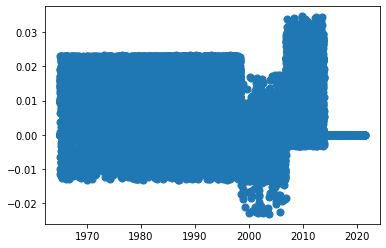

In [13]:
a = glob.glob('/raid60/scratch/leo/scratch/converted_v7/*72357*')
b = eua.CDMDataset(a[0])
b.recordindices['38'][:]

df = b.to_dataframe(groups=['observations_table', 'advanced_homogenisation' ], 
                    variables=['date_time', 'humidity_bias_estimate', 'observed_variable', 'z_coordinate' ])

test = df[df.observed_variable == 38][df.date_time > '1965'][df.z_coordinate == 85000]

fig, ax = plt.subplots()
ax.scatter(test.date_time, test.humidity_bias_estimate, label='CDS', s=50)
plt.show()

2021-07-02 08:52:48,561 INFO Reading Profile on slice(None, None, None)
2021-07-02 08:52:50,843 INFO Welcome to the CDS
2021-07-02 08:52:50,844 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-07-02 08:52:51,193 INFO Request is completed
2021-07-02 08:52:51,194 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data1/adaptor.comprehensive_upper_air.retrieve-1625142273.16007-15730-4-03f339bb-7dbf-4335-8b45-75265c7f36e3.zip to download.zip (31.9M)
2021-07-02 08:52:54,874 INFO Download rate 8.7M/s   
2021-07-02 08:52:55,262 INFO Reading Profile on slice(None, None, None)


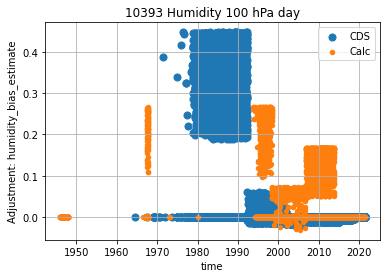

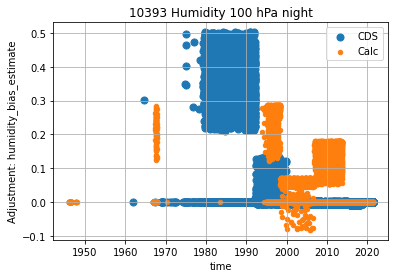

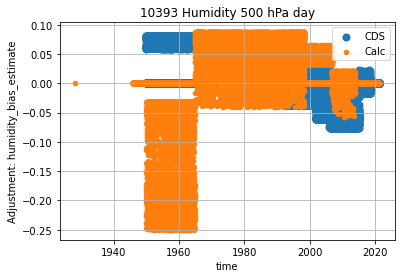

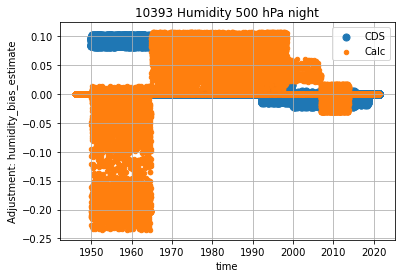

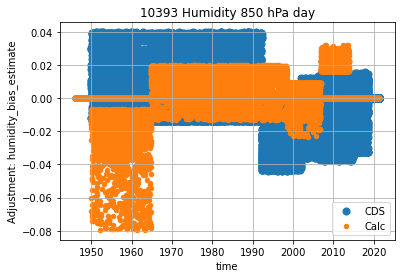

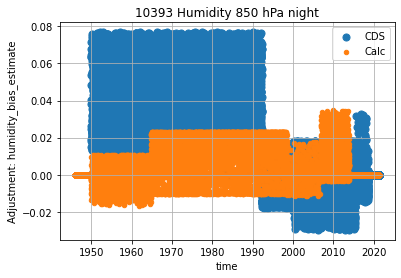

In [14]:
station = '10393'
dd, nd, dcd, ncd = get_adj(station)

plt_adj(dcd, dd, 100, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd, nd, 100, station, 'night', 'humidity_bias_estimate', save=True)
plt_adj(dcd, dd, 500, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd, nd, 500, station, 'night', 'humidity_bias_estimate', save=True)
plt_adj(dcd, dd, 850, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd, nd, 850, station, 'night', 'humidity_bias_estimate', save=True)